# Import libraries

In [1]:
import os
import sys
import glob
import datetime

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np
import importlib
from process_frames import Processor

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    import pandas as pd
    from tqdm import tqdm
    tqdm.pandas()
from IPython.display import display
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, LassoLars, LassoLarsCV
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, RandomForestRegressor 
import joblib
import seaborn as sn

# Choose options
If you want to process image, set PROCESS_IMAGES to True
If you want to process data, set PROCESS_DATA to True

In [2]:
PROCESS_IMAGES = False
PROCESS_DATA = True

# List images

In [3]:
path = os.getcwd()
os.chdir(path)
sys.path.append(path)
sys.path.append(os.path.join(path, 'scripts'))

path_color = '../data/color/'
path_depth = '../data/depth/'
path_mosaic = '../data/mosaic/'

#Create mosaic path if it not exits
if (not os.path.isdir(path_mosaic)):
    os.mkdir(path_mosaic)

file_list = glob.glob(path_depth+"*")
file_list = [os.path.basename(filename) for filename in file_list]

print(len(file_list),"images found")

2069 images found


# Generate data

In [4]:
if PROCESS_IMAGES:
    processor = Processor()
    areas = {filename: processor.process_image(depth_filename=os.path.join(path_depth, filename),
                          color_filename=os.path.join(path_color, filename),
                          mosaic_path=path_mosaic) for filename in file_list}
    # Prepare data
    remove_areas = []
    for area in areas:    
        if areas[area] is None:  
            remove_areas.append(area)
    for remove in remove_areas:
        del areas[remove]
    areas_dataframe = pd.DataFrame.from_dict(areas, orient='index',
         columns=['area', 'x', 'y', 'width', 'height', 'MA', 'ma', 'centroid_x', 'centroid_y', 'orientation', '% area', 'center distance', 'excentricity', 'perimeter', 'symmetry'])
    areas_dataframe.index.name = 'uuid'
    areas_dataframe.index = areas_dataframe.index.str.replace('.npy', '',)
    print("Generated data")
    display(areas_dataframe.head())
    # Read csv file with weights
    weight_data = pd.read_csv(os.path.join("..", 'data', 'id_weight_sex_uuid.csv'), usecols=['uuid', 'id', 'sex', 'weight'])
    print("Loaded data")
    display(weight_data.head())
    # Save calculated information in csv file
    mix = pd.merge(weight_data, areas_dataframe, on='uuid', how='inner')
    weight_col = mix.pop('weight')
    x_col = mix.pop('x')
    y_col = mix.pop('y')
    centroid_x_col = mix.pop('centroid_x')
    centroid_y_col = mix.pop('centroid_y')
    center_dist_col = mix.pop('center distance')
    mix.insert(13, 'weight', y_col)
    mix.insert(14, 'x', x_col)
    mix.insert(15, 'y', weight_col)
    mix.insert(16, 'centroid_x', centroid_x_col)
    mix.insert(17, 'centroid_y', centroid_y_col)
    mix.insert(18, 'center distance', center_dist_col)
    mix.to_csv(os.path.join("..", 'data', 'id_weight_sex_uuid_data.csv'))
    print("Final data")
    display(mix.head())

# Process data

Load final data


,uuid,id,sex,area,width,height,MA,ma,orientation,% area,excentricity,perimeter,symmetry,weight,x,y,centroid_x,centroid_y,center distance
0,3b144fdfdb9f4e02b0f65aed674fbd72,0268,1,292877.074890,564,312,226.871475,589.829285,-1.305798,46.219501,0.838312,1797.356550,0.734787,105,103,24.5,291.266698,390.794758,61.080786
1,960fd92c91f541f6b85889426c39a0fe,0261,1,308998.472633,648,256,217.185989,681.104919,1.441417,58.533350,1.375974,1741.817446,0.836852,202,80,27.1,328.944662,427.000459,88.995256
2,ca10f050724d47f5971c3530ef341a8d,0236,0,292174.501116,569,324,167.003387,671.221436,1.183508,36.034621,0.864987,1568.812394,0.836188,103,195,25.5,270.915334,489.139166,72.103182
3,46d3f67bbf684992ac945ce7c1991ae7,0238,1,274668.662187,613,210,188.982895,637.330017,1.520453,60.039439,0.751995,1589.508790,0.920896,181,117,25.8,288.285815,444.695562,52.534048
4,ecb27b5ef70c48e69d6296a5e91e3faf,0230,0,302622.334318,510,345,196.767181,568.790527,-1.087220,41.696390,0.698404,1437.391040,0.753610,96,171,25.5,297.283394,422.638323,57.299576


120 images loaded
X data


,sex,area,width,height,MA,ma,orientation,% area,excentricity,perimeter,symmetry
28,1,221777.238120,414,209,182.585297,425.915588,-1.329257,67.953355,0.855151,1079.962546,0.963349
27,1,217269.486881,407,224,194.222672,419.056824,1.333706,67.586482,0.665701,1079.661030,0.943449
332,1,314248.422837,595,275,185.276642,658.309998,1.298409,47.642667,0.642989,1658.177837,0.923788
1220,1,137193.381246,339,317,150.135422,446.289825,0.836455,44.948427,1.075532,1059.082384,0.956113
1692,1,133994.879439,359,312,153.563080,455.706879,0.889977,45.405593,1.639265,1084.052946,0.957276


y data


,weight
28,143
27,184
332,138
1220,152
1692,155


Correlation matrix


c:\users\virgi\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


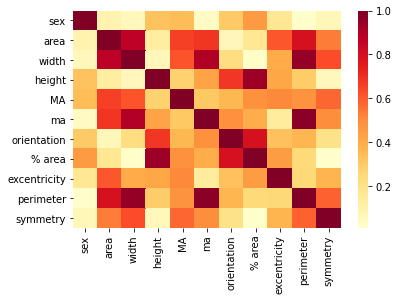

In [45]:
#Load file data
file_data = pd.read_csv(os.path.join("..", 'data', 'id_weight_sex_uuid_data.csv'), usecols=['uuid', 'id', 'sex', 'weight', 'area', 'x', 'y', 'width', 'height', 'MA', 'ma', 'centroid_x', 'centroid_y', 'orientation', '% area', 'center distance', 'excentricity', 'perimeter', 'symmetry'])
print("Load final data")
display(file_data.head())
file_data = file_data[file_data['symmetry']>0.92]
#file_data = file_data[file_data['area']>200000]
file_data = file_data[file_data['% area']>0.5]
file_data = shuffle(file_data)

print(len(file_data),"images loaded")

X = file_data.loc[:, 'sex':'symmetry']
print("X data")
display(X.head())

y = file_data.loc[:, ['weight']]
print("y data")
display(y.head())

#Split data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

if PROCESS_DATA:
    print("Correlation matrix")
    corrMatrix = X.corr().abs()
    sn.heatmap(corrMatrix, cmap="YlOrRd")
    plt.savefig(os.path.join("..", 'data', 'heatmap.jpeg'), bbox_inches='tight')
    
    
    scaler = MinMaxScaler()
    dtree = DecisionTreeClassifier()
    linearRegression = LinearRegression()   
    ridge = Ridge()
    ridgecv = RidgeCV()
    lasso = Lasso()
    lassocv = LassoCV()
    lassolars = LassoLars()
    lassolarscv = LassoLarsCV()

    pipa = Pipeline(steps=[('scaler', scaler), ('classifier', dtree)])

    param_grid = [{'classifier':[linearRegression], 'classifier__fit_intercept': [True,False]},
                      {'classifier':[ridge], 'classifier__fit_intercept': [True,False], 'classifier__alpha': np.arange(0.5,2.5,0.1)},
                      {'classifier':[ridgecv], 'classifier__fit_intercept': [True,False], 'classifier__scoring':['r2']},
                      {'classifier':[lasso], 'classifier__fit_intercept': [True,False], 'classifier__alpha': np.arange(0.5,2.5,0.1), 'classifier__selection':['cyclic', 'random']},
                      {'classifier':[lassocv], 'classifier__fit_intercept': [True,False], 'classifier__selection':['cyclic', 'random']},
                      {'classifier':[lassolars], 'classifier__fit_intercept': [True,False], 'classifier__alpha': np.arange(0.5,2.5,0.1)},
                      {'classifier':[lassolarscv], 'classifier__fit_intercept': [True,False]}
                 ]

    scoring_methods = ['r2', 'explained_variance', 'max_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 
                       'neg_root_mean_squared_error', 'neg_median_absolute_error']
    gs = GridSearchCV(estimator=pipa,
                      param_grid=param_grid,
                      #cv=30,
                      refit='r2',
                      return_train_score=True,
                      n_jobs=30,
                      pre_dispatch=30,
                      scoring=scoring_methods,
                      iid=False)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=FutureWarning)
        gs.fit(X_train, y_train.values.ravel())

    joblib.dump({'gs': gs,
                 'scaler': scaler,
                 'linearRegression': linearRegression,
                 'ridge': ridge,
                 'ridgecv': ridgecv,
                 'lasso': lasso,
                 'lassocv': lassocv,
                 'lassolars': lassolars,
                 'lassolarscv': lassolarscv,
                }, 
                os.path.join("..", 'data', datetime.datetime.now().strftime("%Y%m%d%H%M")+'_model.joblib_dump'))
else:
    #Load last model
    os.chdir(os.path.join("..", 'data'))
    files = glob.glob("*.joblib_dump")
    files.sort(reverse=True)
    models = joblib.load(files[0])
    gs = models['gs']
    scaler = models['scaler']
    linearRegression = models['linearRegression']
    ridge = models['ridge']
    ridgecv = models['ridgecv']
    lasso= models['lasso']
    lassocv = models['lassocv']
    lassolars = models['lassolars']
    lassolarscv = models['lassolarscv']

In [46]:
best_estimator = gs.best_estimator_
print('Best model:', best_estimator.named_steps.classifier)

resultados = pd.DataFrame(gs.cv_results_)
resultados['param_classifier'] = resultados.param_classifier.astype(str).str.split('(', expand=True)[0]
resultados.head()
mejores_resultados_por_tipo_de_modelo = pd.pivot_table(data=resultados,
               index='param_classifier',
               values = ['mean_test_r2', 'std_test_r2',
                            'mean_test_explained_variance', 'std_test_explained_variance',
                            'mean_test_max_error', 'std_test_max_error',
                            'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error',
                            'mean_test_neg_mean_squared_error', 'std_test_neg_mean_squared_error', 
                             'mean_test_neg_root_mean_squared_error'
                        ],
               aggfunc='max'
              ).reindex(['mean_test_r2', 'mean_test_explained_variance', 'mean_test_max_error', 'mean_test_neg_mean_absolute_error',
                         'mean_test_neg_root_mean_squared_error', 'std_test_r2', 'std_test_explained_variance', 'std_test_max_error', 'std_test_neg_mean_absolute_error',
                        ], axis=1)
print('Mean scores during Cross Validation')
mejores_resultados_por_tipo_de_modelo.sort_values(by='mean_test_r2', ascending=False, inplace=True)
(mejores_resultados_por_tipo_de_modelo).round(4)

Best model: RidgeCV(alphas=array([ 0.1,  1. , 10. ]), scoring='r2')
Mean scores during Cross Validation


,mean_test_r2,mean_test_explained_variance,mean_test_max_error,mean_test_neg_mean_absolute_error,mean_test_neg_root_mean_squared_error,std_test_r2,std_test_explained_variance,std_test_max_error,std_test_neg_mean_absolute_error
param_classifier,,,,,,,,,
RidgeCV,0.9147,0.9179,-26.2173,-5.5082,-8.2460,0.0459,0.0482,10.4485,1.5555
LassoLarsCV,0.9018,0.9050,-25.1236,-5.4416,-8.1394,0.0814,0.0758,10.6332,1.4402
LassoCV,0.8978,0.9012,-25.6786,-5.5128,-8.2707,0.0848,0.0790,10.9792,1.4823
Lasso,0.8746,0.8800,-28.9270,-7.0649,-10.1099,0.1338,0.1233,31.2884,2.7229
Ridge,0.8740,0.8817,-31.2224,-6.8563,-10.3492,0.2866,0.1786,21.5803,4.5231
LinearRegression,0.8709,0.8749,-29.1581,-6.0947,-9.2362,0.1005,0.0952,11.2534,2.0542
LassoLars,0.7117,0.7326,-41.1611,-10.6388,-15.2685,0.1373,0.1230,32.6861,2.9397


In [49]:
from sklearn.metrics import r2_score, explained_variance_score, max_error, mean_absolute_error
best_estimator_predictions = best_estimator.predict(X_test)
print('R2 score:', r2_score(y_test, best_estimator_predictions))
print('Explained vairance score:', explained_variance_score(y_test, best_estimator_predictions))
print('Max error:', max_error(y_test, best_estimator_predictions))
print('Mean absolute error:', mean_absolute_error(y_test, best_estimator_predictions))

R2 score: 0.9265847435364973
Explained vairance score: 0.9359268109383376
Max error: 38.48595570258891
Mean absolute error: 7.782940496496593


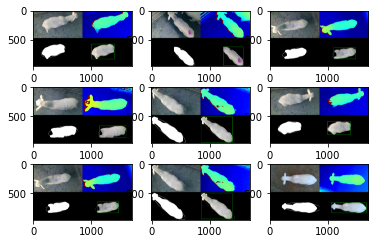

In [50]:
files = []
for i in range(0,len(best_estimator_predictions)):
    difference = abs(best_estimator_predictions[i]-y_test.iloc[i].weight) 
    if difference>1:
        uuid = file_data.loc[y_test.iloc[i].name].uuid
        files.append(uuid)

for i in range(0,9):
    plt.subplot(3,3,i+1)
    img=mpimg.imread(os.path.join("..", 'data', 'mosaic', files[i]+'_mosaico.png'))
    imgplot = plt.imshow(img)

plt.savefig(os.path.join("..", 'data', 'mismatch.jpeg'), bbox_inches='tight')